In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
import pandas as pd
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import glob
import os
import random

#classes = ('plane', 'car', 'bird', 'cat',
#           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

%matplotlib inline

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
data_dir

WindowsPath('C:/Users/i25764/.keras/datasets/flower_photos')

In [ ]:
classes = os.listdir(path=data_dir)
classes.remove('LICENSE.txt')
classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
len(list(data_dir.glob("*/*.jpg")))

3670

roses


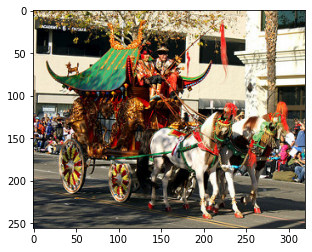

In [ ]:
from PIL import Image 
_class = random.choice(classes)
img_path = random.choice(list(data_dir.glob(f"{_class}/*.jpg")))
plt.imshow(Image.open(img_path)) 
print(f"{_class}")
plt.show()

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)
seed = 0

training_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                   labels="inferred",
                                                                   image_size=IMG_SIZE,
                                                                   batch_size= BATCH_SIZE,
                                                                   shuffle=True,
                                                                   subset='training',
                                                                   validation_split=0.2,
                                                                   label_mode='categorical',
                                                                   seed=seed)

testing_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                   labels="inferred",
                                                                   image_size=IMG_SIZE,
                                                                   batch_size= BATCH_SIZE,
                                                                   shuffle=True,
                                                                   subset='validation',
                                                                   validation_split=0.2,
                                                                   label_mode='categorical',
                                                                   seed=seed)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
next(iter(training_data))

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
 array([[[[ 13.242347  ,  36.885204  ,  11.492347  ],
          [ 14.045918  ,  34.14286   ,  11.77296   ],
          [ 14.859694  ,  29.854591  ,  10.997449  ],
          ...,
          [158.89284   , 172.75002   , 159.89282   ],
          [162.13011   , 174.51021   , 159.35713   ],
          [163.53574   , 174.99232   , 157.90048   ]],
 
         [[ 14.214286  ,  39.785717  ,  13.596939  ],
          [ 15.362245  ,  36.35459   ,  13.571429  ],
          [ 15.051021  ,  32.035713  ,  13.079082  ],
          ...,
          [153.53569   , 167.39287   , 152.40813   ],
          [155.42603   , 168.46428   , 150.84694   ],
          [156.0587    , 168.29591   , 148.27292   ]],
 
         [[ 15.719388  ,  41.64796   ,  16.82398   ],
          [ 16.        ,  39.07143   ,  15.765306  ],
          [ 16.058674  ,  35.237244  ,  15.272959  ],
          ...,
          [148.17856   , 162.03574   , 145.36728   ],
          [149.63521   , 

In [ ]:
def do_augmentation():
    
    data_augmentation_layers = tf.keras.Sequential()
    data_augmentation_layers.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation_layers.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
    
    return data_augmentation_layers    

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(include_top=False,weights='imagenet',input_shape=IMG_SIZE + (3,))

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
base_model.trainable

True

In [ ]:
def get_model():
    
    input_shape = IMG_SIZE + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                   weights='imagenet',
                                                   input_shape=input_shape)
    
    base_model.trainable = False 
    
    inputs = tf.keras.Input(shape=input_shape)
    
    X = do_augmentation()(inputs)
    
    #ToDO : Understand what kind of preproccessing goes here
    X = preprocess_input(X)
    
    X = base_model(X, training=False)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    
    X = tf.keras.layers.Dropout(0.2)(X)
    
    output = tf.keras.layers.Dense(len(classes))(X)
    
    model = tf.keras.Model(inputs,output)
    
    return model

In [ ]:
model = get_model()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [ ]:
lr = 0.001
model.compile(metrics=['accuracy'], 
               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer= tf.keras.optimizers.Adam(learning_rate=lr))

In [ ]:
initial_epochs = 10
history = model.fit(training_data, validation_data=testing_data, epochs=initial_epochs)

Epoch 1/10
92/92 [==============================] - 56s 607ms/step - loss: 0.3107 - accuracy: 0.8910 - val_loss: 0.3399 - val_accuracy: 0.8856
Epoch 2/10
92/92 [==============================] - 64s 699ms/step - loss: 0.2806 - accuracy: 0.9026 - val_loss: 0.3218 - val_accuracy: 0.8883
Epoch 3/10
92/92 [==============================] - 67s 723ms/step - loss: 0.2849 - accuracy: 0.8982 - val_loss: 0.3264 - val_accuracy: 0.8828
Epoch 4/10
92/92 [==============================] - 67s 730ms/step - loss: 0.2572 - accuracy: 0.9097 - val_loss: 0.3144 - val_accuracy: 0.8828
Epoch 5/10
92/92 [==============================] - 69s 751ms/step - loss: 0.2682 - accuracy: 0.9046 - val_loss: 0.3176 - val_accuracy: 0.8883
Epoch 6/10
92/92 [==============================] - 74s 806ms/step - loss: 0.2601 - accuracy: 0.9108 - val_loss: 0.3228 - val_accuracy: 0.8924
Epoch 7/10
92/92 [==============================] - 73s 789ms/step - loss: 0.2451 - accuracy: 0.9169 - val_loss: 0.3151 - val_accuracy: 0.8937

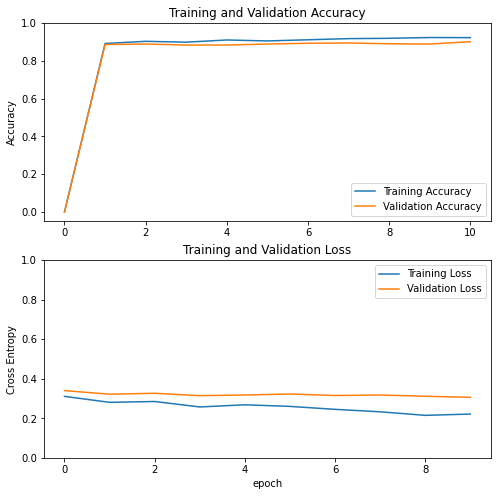

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### UnFreezing more number of layers

In [ ]:
len(base_model.layers)

154

In [ ]:
base_model.trainable = True

fine_tune_from = 20

for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

In [ ]:
model.compile(metrics=['accuracy'], 
               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer= tf.keras.optimizers.Adam(learning_rate=lr))

In [ ]:
new_epochs = 20

history_unfreeze = model.fit(training_data,
                              validation_data=testing_data,
                              epochs=initial_epochs +new_epochs,
                              initial_epoch=history.epoch[-1])

Epoch 10/30
92/92 [==============================] - 59s 628ms/step - loss: 0.6130 - accuracy: 0.8910 - val_loss: 0.8126 - val_accuracy: 0.8624
Epoch 11/30
92/92 [==============================] - 64s 700ms/step - loss: 0.6715 - accuracy: 0.8818 - val_loss: 0.8325 - val_accuracy: 0.8610
Epoch 12/30
92/92 [==============================] - 70s 759ms/step - loss: 0.4790 - accuracy: 0.9087 - val_loss: 0.7525 - val_accuracy: 0.8706
Epoch 13/30
92/92 [==============================] - 68s 734ms/step - loss: 0.4246 - accuracy: 0.9128 - val_loss: 0.7525 - val_accuracy: 0.8774
Epoch 14/30
92/92 [==============================] - 68s 739ms/step - loss: 0.4782 - accuracy: 0.9080 - val_loss: 0.9413 - val_accuracy: 0.8474
Epoch 15/30
92/92 [==============================] - 69s 745ms/step - loss: 0.4991 - accuracy: 0.9022 - val_loss: 0.8603 - val_accuracy: 0.8651
Epoch 16/30
92/92 [==============================] - 69s 745ms/step - loss: 0.5114 - accuracy: 0.9080 - val_loss: 0.8063 - val_accuracy:

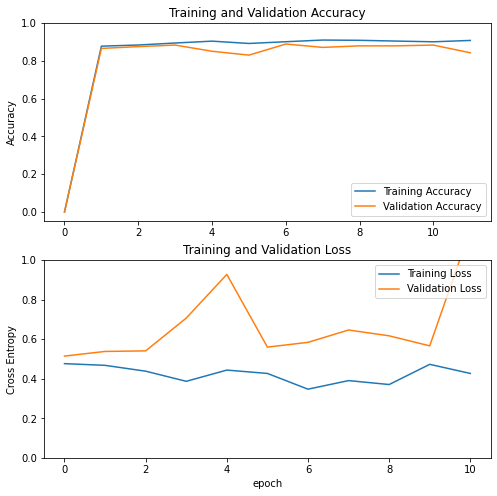

In [ ]:
acc = [0.] + history_unfreeze.history['accuracy']
val_acc = [0.] + history_unfreeze.history['val_accuracy']

loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#!mkdir -p saved_model
model.save('saved_model/flower_model_with_mobilenet_weights.h5')